<a href="https://colab.research.google.com/github/cyxCHENYUXUAN/clyginxiut/blob/Deep-Learning-And-Neural-Network/%E8%BD%A6%E7%89%8C%E8%AF%86%E5%88%ABdemo%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 车牌识别

## 0 摘要

选择BasicBlock+ResNet18模型，每层的BasicBlock后面加上一个dropout，ResNet18的全连接层后面加上一层八分类，先把训练集的整张图片给模型训练，再用训练好的模型对测试集的整张图片进行预测得到一个baseline。

下一步观察训练集中车牌的整体分布情况，在y方向得到车牌分布的阈值，然后将这部分区域截取出来，对这部分区域进行透视变换，接着对图片进行各种形态学操作得到车牌轮廓。

## 1 输入整张图片预测八个标签


### 1.1 模型框架：基于resnet18，全连接层后面接8个分类

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, conv11=False):
        super(BasicBlock, self).__init__()
        self.conv11 = conv11

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=0.65)#dropout缓解过拟合

        if self.conv11:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
            self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.conv2(y)
        y = self.bn2(y)
        y = self.dropout(y)
        if self.conv11:
            x = self.conv3(x)
            x = self.bn3(x)
        y += x
        return self.relu2(y)

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.a1 = BasicBlock(64, 64)
        self.a2 = BasicBlock(64, 64)

        self.b1 = BasicBlock(64, 128, stride=2, conv11=True)
        self.b2 = BasicBlock(128, 128)

        self.c1 = BasicBlock(128, 256, stride=2, conv11=True)
        self.c2 = BasicBlock(256, 256)

        self.d1 = BasicBlock(256, 512, stride=2, conv11=True)
        self.d2 = BasicBlock(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d([1, 1])
        self.flatten = nn.Flatten()

        self.classify = nn.ModuleList([nn.Linear(512, 34) for i in range(8)])

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.maxpool1(y)

        y = self.a1(y)
        y = self.a2(y)
        y = self.b1(y)
        y = self.b2(y)
        y = self.c1(y)
        y = self.c2(y)
        y = self.d1(y)
        y = self.d2(y)

        y = self.avgpool(y)
        y = self.flatten(y)
        y = [i(y) for i in self.classify]

        return y

整张图片测试集上准确率：0.452

### 1.2 数据分布

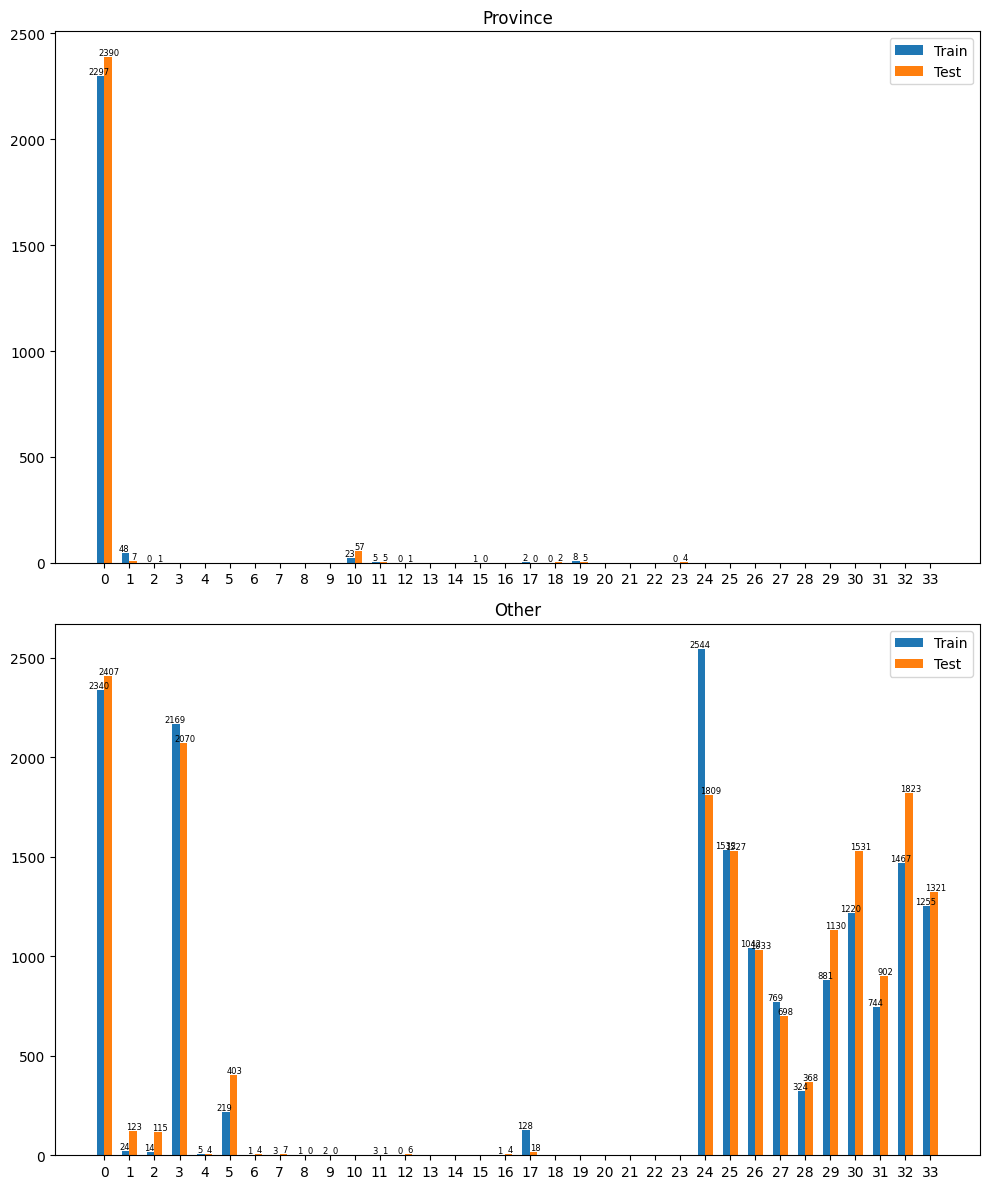

In [ ]:
labels = list(range(34))
x = np.arange(34)

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

train_values_1 = list(train_label_dict_1.values())
test_values_1 = list(test_label_dict_1.values())
ax[0].bar(x - 0.15, train_values_1, width=0.3, label='Train')
ax[0].bar(x + 0.15, test_values_1, width=0.3, label='Test')
ax[0].set_title('Province')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

train_values_2 = list(train_label_dict_2.values())
test_values_2 = list(test_label_dict_2.values())
ax[1].bar(x - 0.15, train_values_2, width=0.3, label='Train')
ax[1].bar(x + 0.15, test_values_2, width=0.3, label='Test')
ax[1].set_title('Other')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

def add_values(ax, values1, values2, x, offset):
    for i in range(len(x)):
        if values1[i] > 0 or values2[i] > 0:

                ax.text(x[i] - 0.2, values1[i], str(values1[i]), ha='center', va='bottom', fontsize=6)

                ax.text(x[i] + 0.2, values2[i], str(values2[i]), ha='center', va='bottom', fontsize=6)

add_values(ax[0], train_values_1, test_values_1, x, 1)
add_values(ax[1], train_values_2, test_values_2, x, 1)

plt.tight_layout()
plt.show()

在省份中：2,12,18和23类在训练集上没有。

在字母和数字中：12类在训练集上没有,且训练集上的有的类数据量小，不一定学习到了。

所以模型很显然是欠拟合，数据分布不均衡，并不是每个类都有数据。

## 2 先提取车牌区域，再预测八个标签

### 2.1 用图像处理方式提取车牌区域

#### 2.1.1 观察数据分布：截取上下不太可能出现的区域

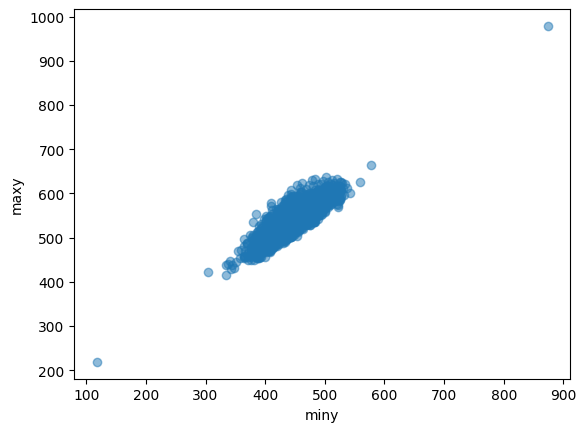

In [ ]:
import zipfile
import os
import cv2
import re
import matplotlib.pyplot as plt

zip_path = '/content/drive/MyDrive/train.zip'
extract_path = '/content/extracted_new'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

train_dir = '/content/extracted_new/train'
img_path = [os.path.join(train_dir,file) for file in os.listdir(train_dir)]
miny = []
maxy = []
for imgp in img_path:
    count_right = 0
    count_jiayin = 0
    count_err = 0
    if imgp.endswith('.jpg'):
      img = cv2.imread(imgp)
      plot = os.path.splitext(os.path.basename(imgp))[0].split("-")[3]
      flag = os.path.splitext(os.path.basename(imgp))[0].split("-")[4].split("_")
      plott = os.path.splitext(os.path.basename(imgp))[0].split("-")[2]
      plott = re.split(r'[&_]', plott)

      pl = re.split(r'[&_]', plot)
      rbx,rby = int(pl[0]), int(pl[1])
      lbx,lby = int(pl[2]), int(pl[3])
      ltx,lty = int(pl[4]), int(pl[5])
      rtx,rty = int(pl[6]), int(pl[7])

      ty = min(lby, lty, rby, rty)
      by = max(lby, lty, rby, rty)
      miny.append(ty)
      maxy.append(by)

plt.scatter(miny, maxy, alpha=0.5)
plt.xlabel("miny")
plt.ylabel("maxy")
plt.show()

In [ ]:
miny = sorted(miny)
maxy = sorted(maxy)
print("top:", miny[2], "bottom:", maxy[-4])

top: 334 bottom: 633


#### 2.1.2 提取车牌

sobel算子只提取X方向的边缘，相对于两边都做，线条更少，有利于后续膨胀腐蚀操作。

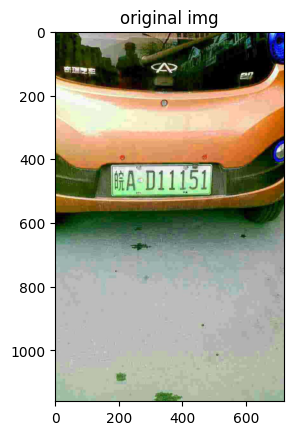

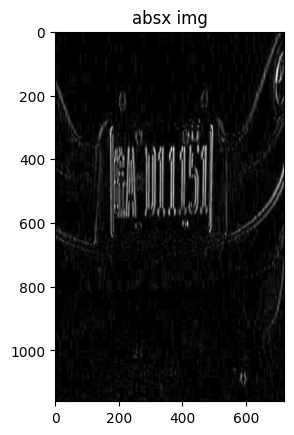

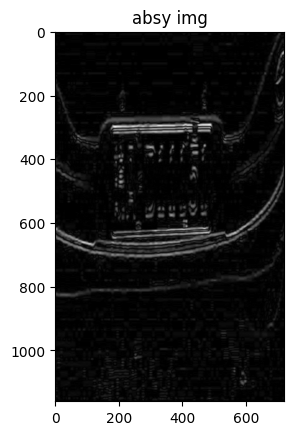

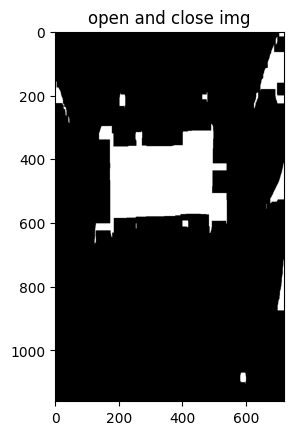

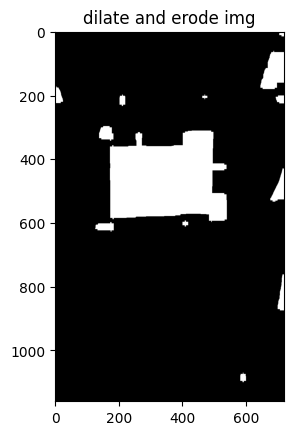

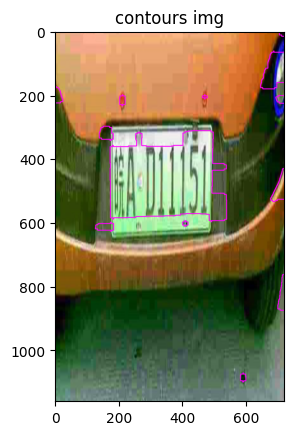

IoU: 0.790769394374435


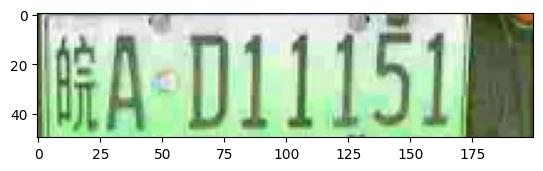

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re

def IoU(rect1, rect2):
    x1 = max(rect1[0], rect2[0])
    y1 = max(rect1[1], rect2[1])
    x2 = min(rect1[2], rect2[2])
    y2 = min(rect1[3], rect2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    rect1_area = (rect1[2] - rect1[0]) * (rect1[3] - rect1[1])
    rect2_area = (rect2[2] - rect2[0]) * (rect2[3] - rect2[1])
    union_area = rect1_area + rect2_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0
    return iou

def read_images_from_folder(folder_path):

    count_right = 0
    iou_sum = 0
    break_flag = False
    output_folder = os.path.join(folder_path, 'plate_images11')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for root, dirs, files in os.walk(folder_path):
        for filename in files:

            file_path = os.path.join(root, filename)

            img = cv2.imread(file_path)

            M = cv2.getPerspectiveTransform(np.float32([[0,334], [720,334], [0,663], [720, 663]]),
                             np.float32([[0, 0], [720, 0], [0, 1160], [720, 1160]]))
            new_image = cv2.warpPerspective(img, M, (720,1160))
            img_copy1 = new_image.copy()
            img_copy2 = new_image.copy()
            if img is not None:
                plt.imshow(img)
                plt.title("original img")
                plt.show()
                imgp = filename
                plot = os.path.splitext(os.path.basename(imgp))[0].split("-")[3]
                flag = os.path.splitext(os.path.basename(imgp))[0].split("-")[4].split("_")
                plott = os.path.splitext(os.path.basename(imgp))[0].split("-")[2]
                plott = re.split(r'[&_]', plott)
                pl = re.split(r'[&_]', plot)
                original_points = np.float32([[int(pl[0]), int(pl[1])], [int(pl[2]), int(pl[3])], [int(pl[4]), int(pl[5])], [int(pl[6]), int(pl[7])]])
                transformed_points1 = []
                for point in original_points:
                  point_homogeneous = np.append([point], 1)
                  transformed_point_homogeneous = np.dot(M, point_homogeneous)
                  transformed_point = transformed_point_homogeneous[:2] / transformed_point_homogeneous[2]
                  transformed_points1.append(transformed_point)
                transformed_points1 = np.array(transformed_points1, dtype=np.float32)

                gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
                gray = cv2.GaussianBlur(gray,(11,11),0)
                x = cv2.Sobel(gray, cv2.CV_16S, 1, 0)
                absX = cv2.convertScaleAbs(x)
                plt.imshow(absX, cmap = 'gray')
                plt.title("absx img")
                plt.show()

                y = cv2.Sobel(gray, cv2.CV_16S, 0, 1)
                absY = cv2.convertScaleAbs(y)
                plt.imshow(absY, cmap = 'gray')
                plt.title("absy img")
                plt.show()

                ret, binary = cv2.threshold(absX, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
                open = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
                kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (45,15))
                close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, kernel1)
                plt.imshow(close, cmap = 'gray')
                plt.title("open and close img")
                plt.show()

                kernel_x = cv2.getStructuringElement(cv2.MORPH_CROSS, (15, 9))
                kernel_y = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 13))
                dilate = cv2.morphologyEx(close, cv2.MORPH_DILATE, kernel_y,5)
                erode = cv2.morphologyEx(dilate, cv2.MORPH_ERODE, kernel_y,15)
                erode = cv2.morphologyEx(erode, cv2.MORPH_ERODE, kernel_x,11)
                dilate = cv2.morphologyEx(erode, cv2.MORPH_DILATE, kernel_x,15)
                plt.imshow(dilate, cmap = 'gray')
                plt.title("dilate and erode img")
                plt.show()

                contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                img_copy1 = cv2.drawContours(img_copy1, contours, -1, (255,0,255), 2)
                plt.imshow(img_copy1, cmap = 'gray')
                plt.title("contours img")
                plt.show()

                max_green_mean = 0
                final_plate_contour = None
                found_plate = False

                for contour in contours:
                    rect = cv2.boundingRect(contour)
                    width, height = rect[2], rect[3]
                    x, y, w, h = rect
                    vertex_top_left = (x, y)      # 左上角
                    vertex_top_right = (x + w, y)  # 右上角
                    vertex_bottom_right = (x + w, y + h)  # 右下角
                    vertex_bottom_left = (x, y + h)  # 左下角
                    plate_region = img_copy2[y:y+h, x:x+w]
                    vertices = np.array([(x + w, y + h),(x, y + h),(x, y),(x + w, y)], dtype=np.float32)  # 确保类型为 float32

                    if (width > height * 1.04 and width < height * 2.12) or (height > width * 1.04 and height < width * 2.12):
                        if (width * height > 10000) and (width > 175):

                            b, g, r = cv2.split(plate_region)
                            green_mean = np.mean(g)
                            if green_mean > max_green_mean:
                                max_green_mean = green_mean
                                final_plate_contour = contour
                                final_rect = rect
                                iou = IoU([x,y,x+w,y+h],[int(transformed_points1[2][0]), int(transformed_points1[2][1]), int(transformed_points1[0][0]), int(transformed_points1[0][1])])
                                print(f'IoU: {iou}')
                                iou_sum += iou
                                count_right += 1
                                found_plate = True
                                break
                rect = cv2.boundingRect(final_plate_contour)
                x, y, w, h = rect
                final_plate_region = img_copy2[y:y+h, x:x+w]
                plt.imshow(cv2.resize(final_plate_region,(200,50)) , cmap = 'gray')
                plt.show()
                final_plate_region = cv2.resize(final_plate_region,(200,50))
                output_file_path = os.path.join(output_folder, os.path.basename(file_path))
                cv2.imwrite(output_file_path, final_plate_region)
            break
        break

folder_path = '/content/extracted/train'
read_images_from_folder(folder_path)

训练集上的平均IOU为：0.75

### 2.2 滑动窗口提取车牌

每张图片采集八个正样本和八个负样本，负样本不采用随机采取，不一定能采集到好的数据，采用固定采取。

负样本区域如下：因为有的车皮可能为绿色，因此在车牌左右两部分分别取一个负样本；车牌上方可能有广告，所以在车牌上面取两个负样本；考虑到有的图片中的街道被拍成绿色，因此在图片的左下角和右下角分别取一个负样本；图片上方可能有树叶等绿色样本，因此在图片的左上角和右上角分别取一个负样本。

正样本区域如下：滑动窗口中车牌区域占整个窗口区域的70%以上视为正样本

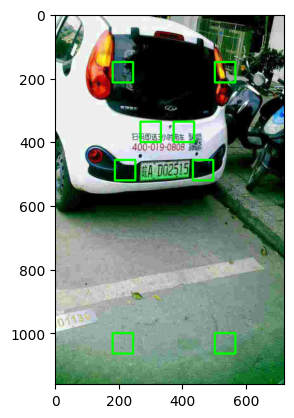

In [ ]:
imgp = "/content/extracted_new/train/00969184027778-89_269-267&457_421&520-421&512_268&520_267&462_420&457-0_0_3_24_26_29_25_29-129-126.jpg"
img = cv2.cvtColor(cv2.imread(imgp), cv2.COLOR_BGR2RGB)

plot = os.path.splitext(os.path.basename(imgp))[0].split("-")[3]
pl = re.split(r'[&_]', plot)
rbx,rby = int(pl[0]), int(pl[1])
lbx,lby = int(pl[2]), int(pl[3])
ltx,lty = int(pl[4]), int(pl[5])
rtx,rty = int(pl[6]), int(pl[7])

lx = min(lbx, ltx, rbx, rtx)
rx = max(lbx, ltx, rbx, rtx)
ty = min(lby, lty, rby, rty)
by = max(lby, lty, rby, rty)

ws = 64
cv2.rectangle(img, (lx - 80, ty), (lx - 80 + ws, ty + ws), (0, 255, 0), 5)
cv2.rectangle(img, (rx + 10, ty), (rx + 10 + ws, ty + ws), (0, 255, 0), 5)
cv2.rectangle(img, (lx, ty - 120), (lx + ws, ty - 120 + ws), (0, 255, 0), 5)
cv2.rectangle(img, (rx - 50, ty - 120), (rx - 50 + ws, ty - 120 + ws), (0, 255, 0), 5)
cv2.rectangle(img, (180, 1000), (180 + ws, 1000 + ws), (0, 255, 0), 5)
cv2.rectangle(img, (500, 1000), (500 + ws, 1000 + ws), (0, 255, 0), 5)
cv2.rectangle(img, (500, 150), (500 + ws, 150 + ws), (0, 255, 0), 5)
cv2.rectangle(img, (180, 150), (180 + ws, 150 + ws), (0, 255, 0), 5)

plt.imshow(img)
plt.show()

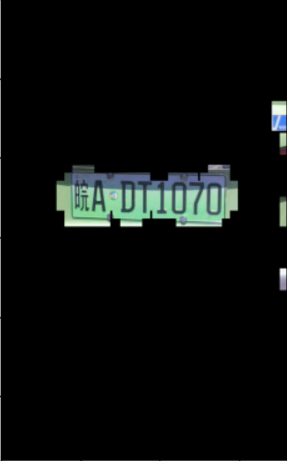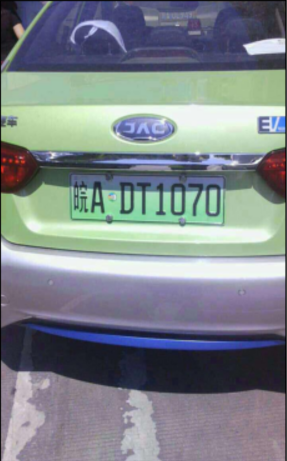

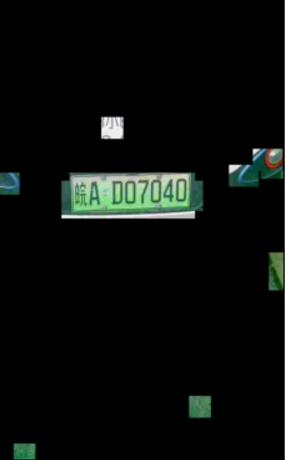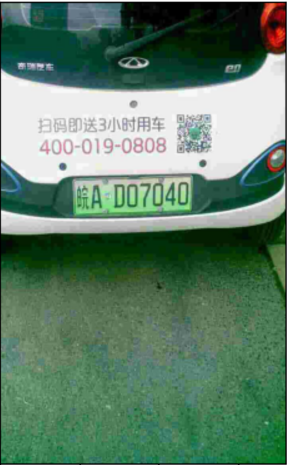

## 3 对车牌区域进行端到端预测

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, conv11=False):
        super(BasicBlock, self).__init__()
        self.conv11 = conv11

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=0.65)#dropout缓解过拟合

        if self.conv11:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
            self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.conv2(y)
        y = self.bn2(y)
        y = self.dropout(y)
        if self.conv11:
            x = self.conv3(x)
            x = self.bn3(x)
        y += x
        return self.relu2(y)

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()                      # 64*256
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)   # 32*128
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)           # 16*64

        self.a1 = BasicBlock(64, 64)
        self.a2 = BasicBlock(64, 64)

        self.b1 = BasicBlock(64, 128, stride=2, conv11=True)          # 8*32
        self.b2 = BasicBlock(128, 128)

        self.c1 = BasicBlock(128, 256, stride=2, conv11=True)          # 4*16
        self.c2 = BasicBlock(256, 256)

        self.d1 = BasicBlock(256, 512, stride=2, conv11=True)          # 2*8
        self.d2 = BasicBlock(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d([1, 1])
        self.flatten = nn.Flatten()

        self.classify = nn.ModuleList([nn.Linear(512, 34) for i in range(8)])

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.maxpool1(y)

        y = self.a1(y)
        y = self.a2(y)
        y = self.b1(y)
        y = self.b2(y)
        y = self.c1(y)
        y = self.c2(y)
        y = self.d1(y)
        y = self.d2(y)

        y = self.avgpool(y)
        y = self.flatten(y)
        y = [i(y) for i in self.classify]

        return y

车牌区域图片测试集上准确率：0.5708

## 4 总结

输入整张图片：训练集准确率最高为94%，测试集准确率最高为45.2%

| 训练集| 测试集|
|---|---|
| 94%| 45.2%|

输入截取车牌后的车牌图片：训练集准确率最高可到99%，测试集上准确率最高为57.08%

|训练集|测试集 |
|---|---|
|99% |57.08% |

在测试集中，截取车牌区域的0.5708比整张图片的0.452提升了10多个百分点